# Bank Marketing Campaign - Opening a Term Deposit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn import tree

from matplotlib.ticker import FuncFormatter

from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import chart_studio.plotly as py

## Loading dataset

In [2]:
#import and printing heading
df = pd.read_csv('bank-full.csv', sep=';')
#this line causes pdays -1 value to be ignored to see how the model changes
#df = df[df['pdays'] != -1]
print(df.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [ ]:
df.columns

In [4]:
print("printing basic data:\n", df.describe())
print("\nchecking if data is null:\n", df.isnull().sum())

printing basic data:
                 age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%  

In [5]:
print("Num of term subscriptions")
df['y'].value_counts()

Num of term subscriptions


y
no     39922
yes     5289
Name: count, dtype: int64

In [6]:
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_data, temp_data = train_test_split(df, test_size=(1 - train_percentage), random_state=42)
val_test_percentage = val_percentage / (val_percentage + test_percentage)
val_data, test_data = train_test_split(temp_data, test_size=val_test_percentage, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 36168
Test set size: 4522
Validation set size: 4521


## Exploratory Data Analysis

### Information on Term Subscriptions

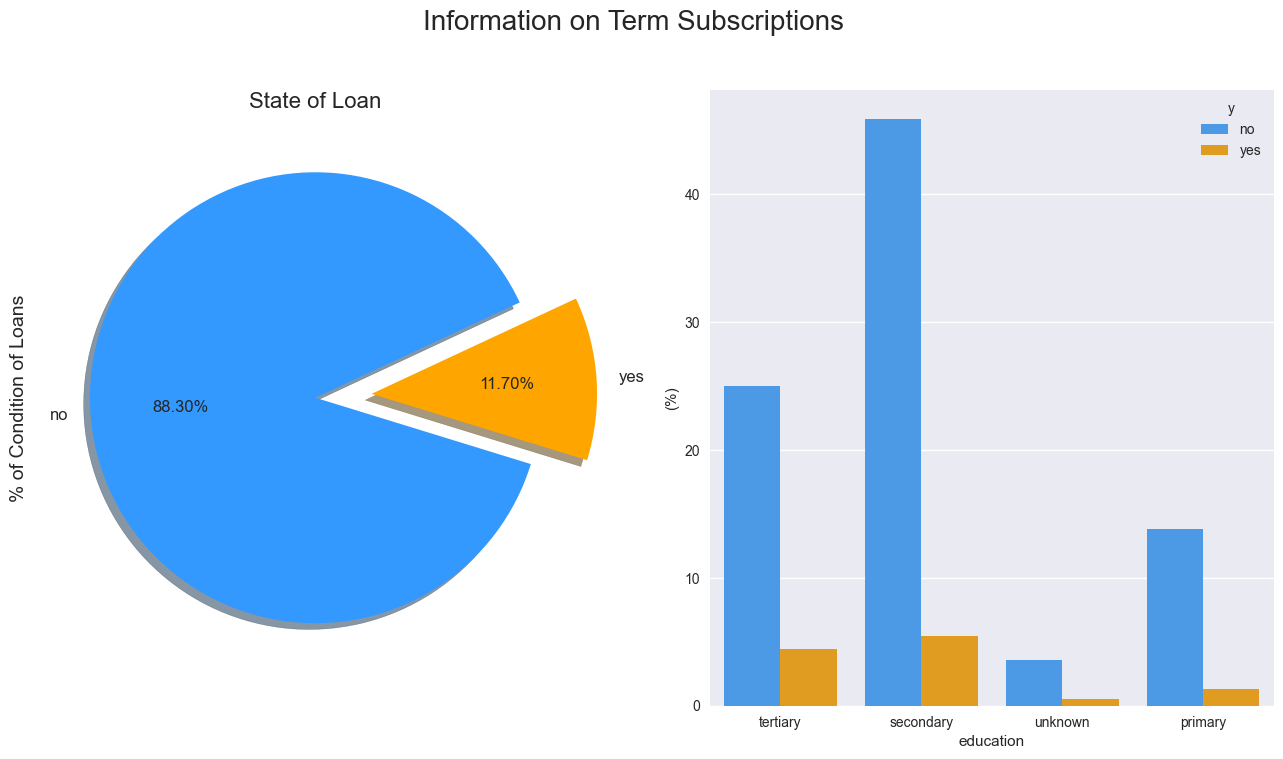

In [33]:
colors = ["#3399ff", "#ffa500"]
palette = ["#3399ff", "#ffa500"]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('Information on Term Subscriptions', fontsize=20)

df["y"].value_counts().plot.pie(
    explode=[0, 0.25],
    autopct='%1.2f%%',
    ax=ax[0],
    shadow=True,
    colors=colors,
    fontsize=12,
    startangle=25
)
ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

sns.barplot(
    x="education",
    y="balance",
    hue="y",
    data=df,
    palette=palette,
    estimator=lambda x: len(x) / len(df) * 100,
    ax=ax[1]
)
ax[1].set_ylabel("(%)")
education_labels = df["education"].unique()
ax[1].set_xticks(range(len(education_labels)))
ax[1].set_xticklabels(education_labels, rotation=0, rotation_mode="anchor")

plt.show()

### Numeric data distribution

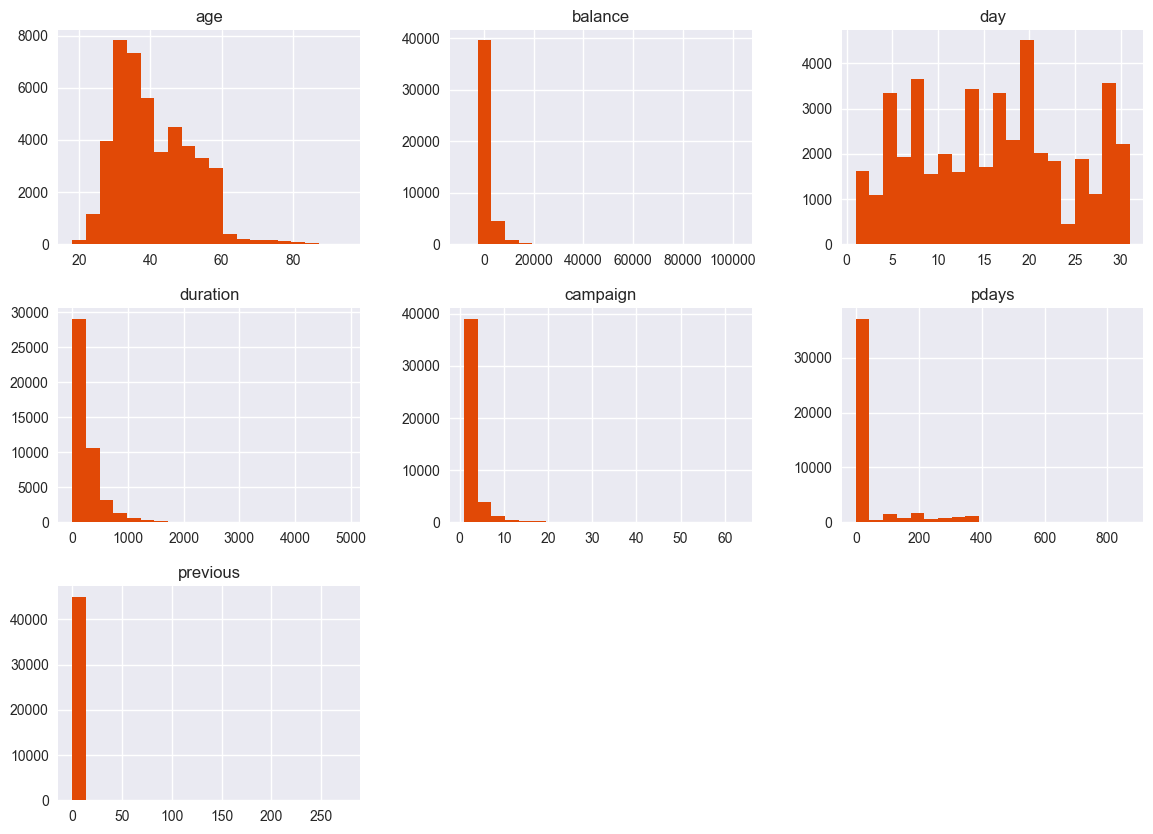

In [29]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

df.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

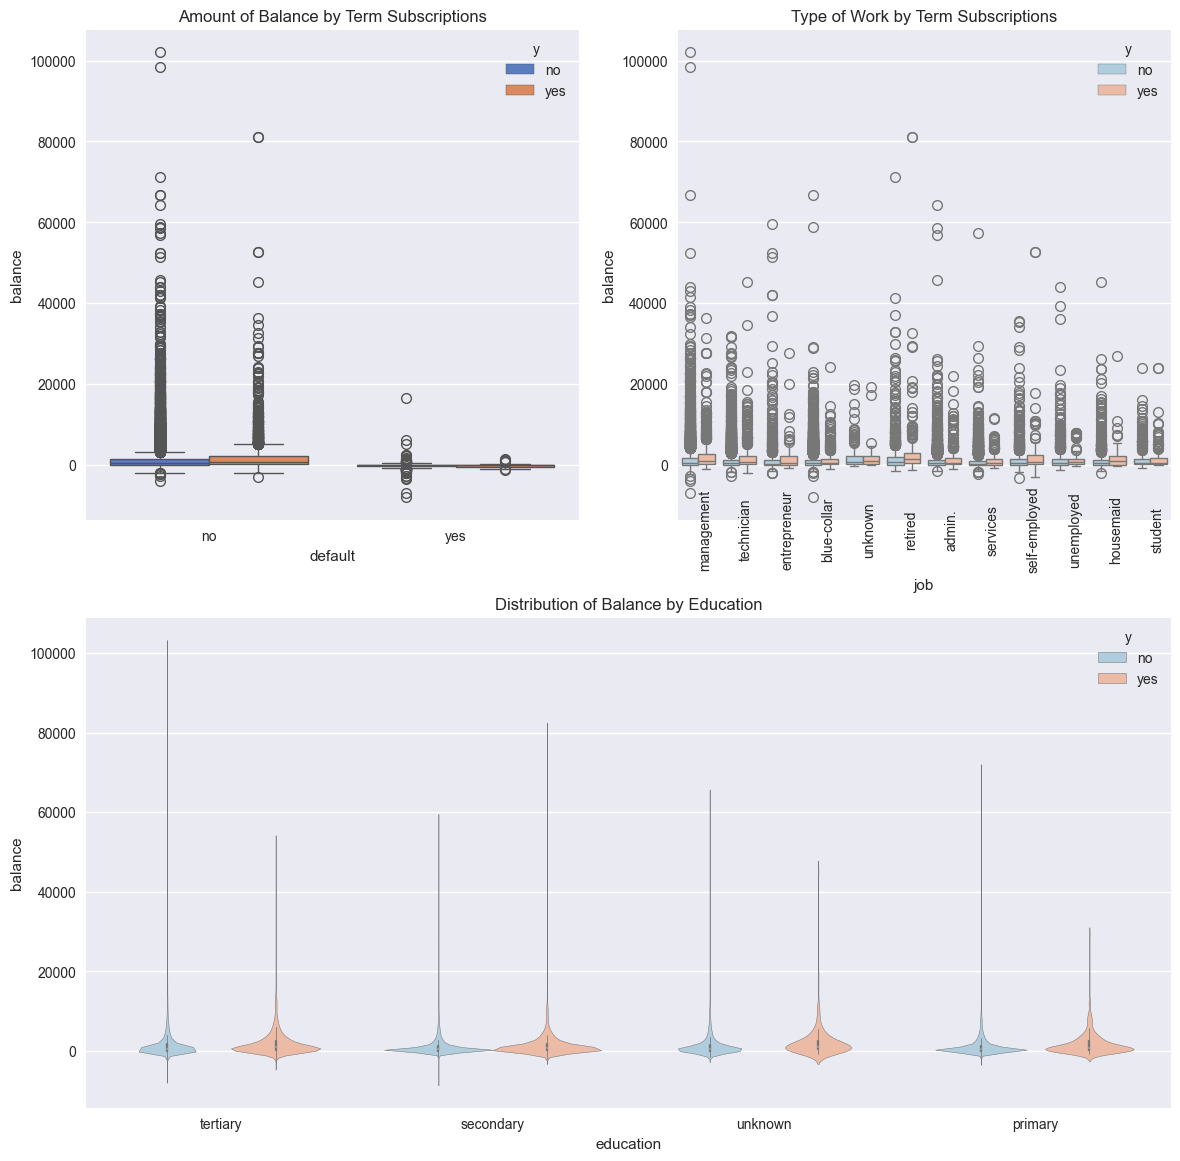

In [34]:
fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

g = sns.boxplot(x="default", y="balance", hue="y", data=df, palette="muted", ax=ax1)
g.set_title("Amount of Balance by Term Subscriptions")

g1 = sns.boxplot(x="job", y="balance", hue="y", data=df, palette="RdBu_r", ax=ax2)
job_labels = df["job"].unique()
job_positions = range(len(job_labels))
g1.set_xticks(job_positions)
g1.set_xticklabels(job_labels, rotation=90, rotation_mode="anchor")
g1.set_title("Type of Work by Term Subscriptions")

g2 = sns.violinplot(data=df, x="education", y="balance", hue="y", palette="RdBu_r", ax=ax3)
g2.set_title("Distribution of Balance by Education")

plt.show()

### Number of Ocupations

In [35]:
import squarify
import random

df = df.drop(df.loc[df["balance"] == 0].index)

x = 0
y = 0
width = 100
height = 100

job_names = df['job'].value_counts().index
values = df['job'].value_counts().tolist()

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

colors = ['rgb(200, 255, 144)','rgb(135, 206, 235)',
          'rgb(235, 164, 135)','rgb(220, 208, 255)',
          'rgb(253, 253, 150)','rgb(255, 127, 80)', 
          'rgb(218, 156, 133)', 'rgb(245, 92, 76)',
          'rgb(252, 64, 68)', 'rgb(154, 123, 91)']

random.shuffle(colors)

shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append(
        dict(
            type = 'rect',
            x0 = r['x'],
            y0 = r['y'],
            x1 = r['x'] + r['dx'],
            y1 = r['y'] + r['dy'],
            line = dict(width=2),
            fillcolor = colors[counter]
        )
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            y = r['y']+(r['dy']/2),
            text = values[counter],
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(colors):
        counter = 0
    
# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects],
    y = [ r['y']+(r['dy']/2) for r in rects],
    text = [ str(v) for v in job_names],
    mode='text',
)

layout = dict(
    title='Number of Occupations',
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

iplot(figure, filename='squarify-treemap')

### Distribution of Ages by Occupation

In [37]:
suscribed_df = df.loc[df["y"] == "yes"]

occupations = df["job"].unique().tolist()

# Get the balances by jobs
management = suscribed_df["age"].loc[suscribed_df["job"] == "management"].values
technician = suscribed_df["age"].loc[suscribed_df["job"] == "technician"].values
services = suscribed_df["age"].loc[suscribed_df["job"] == "services"].values
retired = suscribed_df["age"].loc[suscribed_df["job"] == "retired"].values
blue_collar = suscribed_df["age"].loc[suscribed_df["job"] == "blue-collar"].values
unemployed = suscribed_df["age"].loc[suscribed_df["job"] == "unemployed"].values
entrepreneur = suscribed_df["age"].loc[suscribed_df["job"] == "entrepreneur"].values
housemaid = suscribed_df["age"].loc[suscribed_df["job"] == "housemaid"].values
self_employed = suscribed_df["age"].loc[suscribed_df["job"] == "self-employed"].values
student = suscribed_df["age"].loc[suscribed_df["job"] == "student"].values


ages = [management, technician, services, retired, blue_collar, unemployed, 
         entrepreneur, housemaid, self_employed, student]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
          'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)',
         'rgba(229, 126, 56, 0.5)', 'rgba(229, 56, 56, 0.5)',
         'rgba(174, 229, 56, 0.5)', 'rgba(229, 56, 56, 0.5)']

traces = []

for xd, yd, cls in zip(occupations, ages, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

### Marital status comparison

In [36]:
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

iplot(fig, filename='facet - custom colormap')

### Facet gird of Martial status

In [38]:
fig = ff.create_facet_grid(
    df,
    y='balance',
    facet_row='marital',
    facet_col='y',
    trace_type='box',
)

iplot(fig, filename='facet - box traces')

### The Impact of Duration \n in Opening a Term Deposit

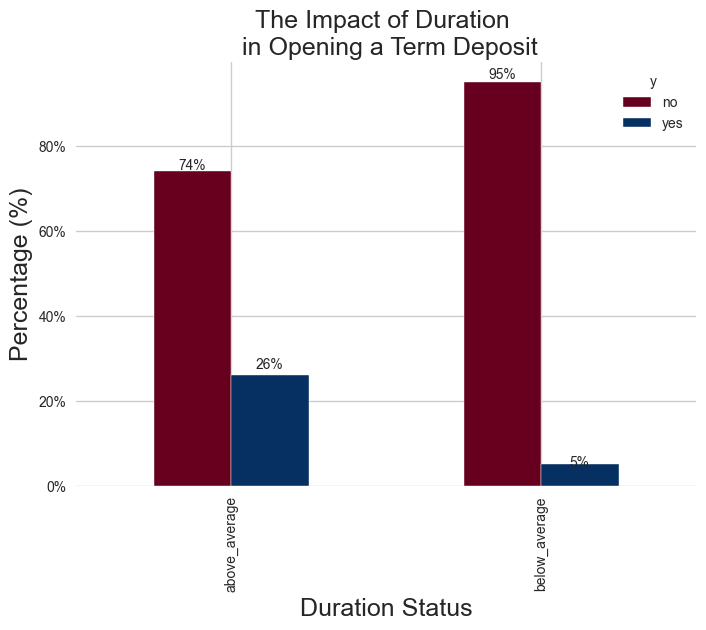

In [73]:
sns.set_style('whitegrid')

def percent(x, pos):
    return '%1.0f%%' % x

avg_duration = df['duration'].mean()

df["duration_status"] = np.nan
df["duration_status"] = df["duration_status"].astype(object)

lst = [df]

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

pct_term = pd.crosstab(df['duration_status'], df['y']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)

ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
plt.title("The Impact of Duration \n in Opening a Term Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18)
plt.ylabel("Percentage (%)", fontsize=18)
ax.yaxis.set_major_formatter(FuncFormatter(percent))

i = 0
for p in ax.patches:
    height_adjustment = 1.02
    if i >= 2:
        height_adjustment = 1.1
    ax.annotate(f'{p.get_height():.0f}%',
                (p.get_x() + p.get_width() / 2., p.get_height() * height_adjustment),
                ha='center', va='center')
    i = i + 1

plt.show()

### Correlation Matrix

In [ ]:
fig = plt.figure(figsize=(12,8))
df['y'] = LabelEncoder().fit_transform(df['y'])

numeric_df = df.select_dtypes(exclude="object")

corr_numeric = numeric_df.corr()

sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### Pair Plot

In [ ]:
sns.pairplot(df, hue='y')
plt.show()

## Logical Regression Classifier

In [10]:
lr_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = lr_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    lr_df[column] = le.fit_transform(lr_df[column])
    label_encoders[column] = le

X = lr_df.drop('y', axis=1)
y = lr_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', C=1.0)
time_start = time.time()
lr.fit(X_train, y_train)
time_end = time.time()
lr_time = time_end - time_start

y_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred)
lr_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * lr_accuracy))
print("Precision score: {:.2f}%".format(100 * lr_precision))
print("Recall score: {:.2f}%".format(100 * lr_recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7952
           1       0.59      0.21      0.31      1091

    accuracy                           0.89      9043
   macro avg       0.75      0.60      0.62      9043
weighted avg       0.86      0.89      0.86      9043

Accuracy score: 88.74%
Precision score: 59.43%
Recall score: 21.08%


In [11]:
lr_train_score = lr.score(X_train, y_train)

print(f"Training Score for Logistic Regression: {lr_train_score:.4f}")
print(f"Training Time for Logistic Regression: {lr_time:.2f} s")

log_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Logistic Regression: {lr_log_reg_mean:.4f}")

Training Score for Logistic Regression: 0.8920
Training Time for Logistic Regression: 0.56 s
Crossval Mean Score for Logistic Regression: 0.8916


### Confusion Matrix for Logistic Regression Model

Confusion Matrix:
[[7795  157]
 [ 861  230]]


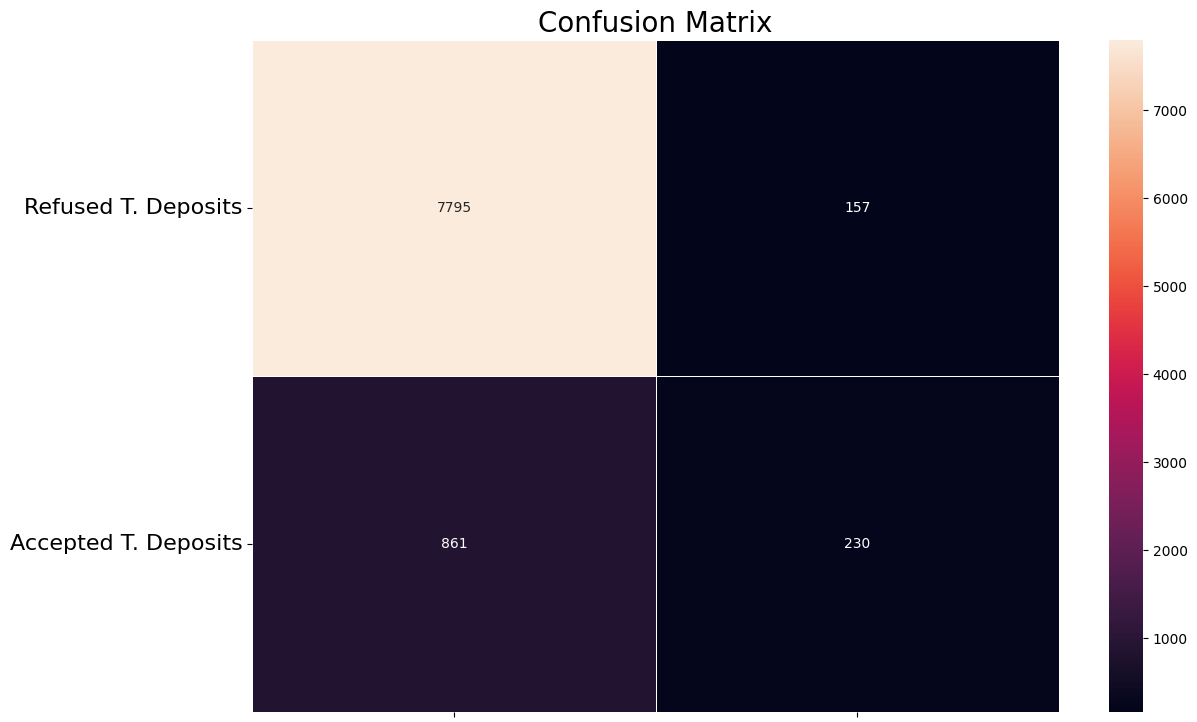

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

### ROC Curve for Logistic Regression Model

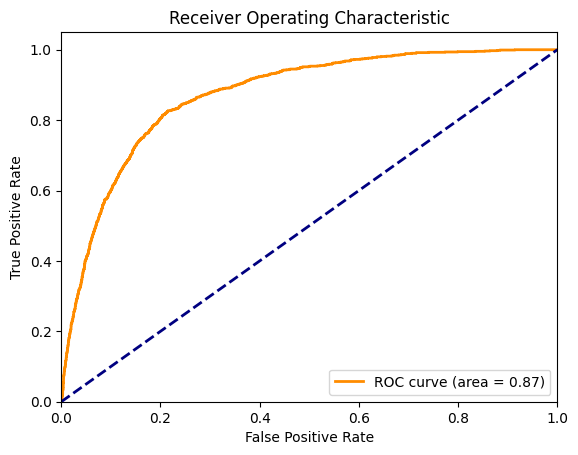

In [13]:
y_pred_proba = lr.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Precision-Recall Curve for Decision Tree

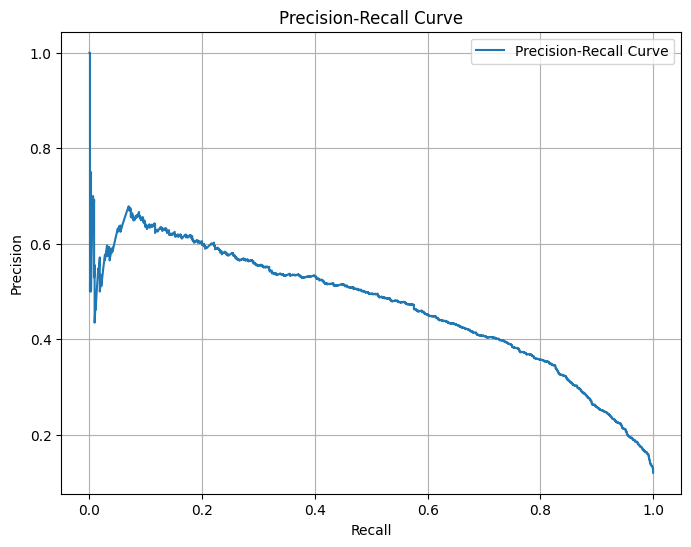

In [14]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree Classifier

In [15]:
dt_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = dt_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    dt_df[column] = le.fit_transform(dt_df[column])
    label_encoders[column] = le

X = dt_df.drop('y', axis=1)
y = dt_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
time_start = time.time()
dt.fit(X_train, y_train)
time_end = time.time()
dt_time = time_end - time_start

y_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * dt_accuracy))
print("Precision score: {:.2f}%".format(100 * dt_precision))
print("Recall score: {:.2f}%".format(100 * dt_recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7952
           1       0.48      0.48      0.48      1091

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.87      0.87      0.87      9043

Accuracy score: 87.40%
Precision score: 47.82%
Recall score: 48.21%


In [16]:
dt_train_score = dt.score(X_train, y_train)

print(f"Training Score for Decision Tree: {dt_train_score:.4f}")
print(f"Training Time for Decision Tree: {dt_time:.2f} s")

log_scores = cross_val_score(dt, X_train, y_train, cv=3)
dt_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Decision Tree: {dt_log_reg_mean:.4f}")

Training Score for Decision Tree: 1.0000
Training Time for Decision Tree: 0.27 s
Crossval Mean Score for Decision Tree: 0.8740


### Confusion Matrix for Decision Tree

Confusion Matrix:
[[7378  574]
 [ 565  526]]


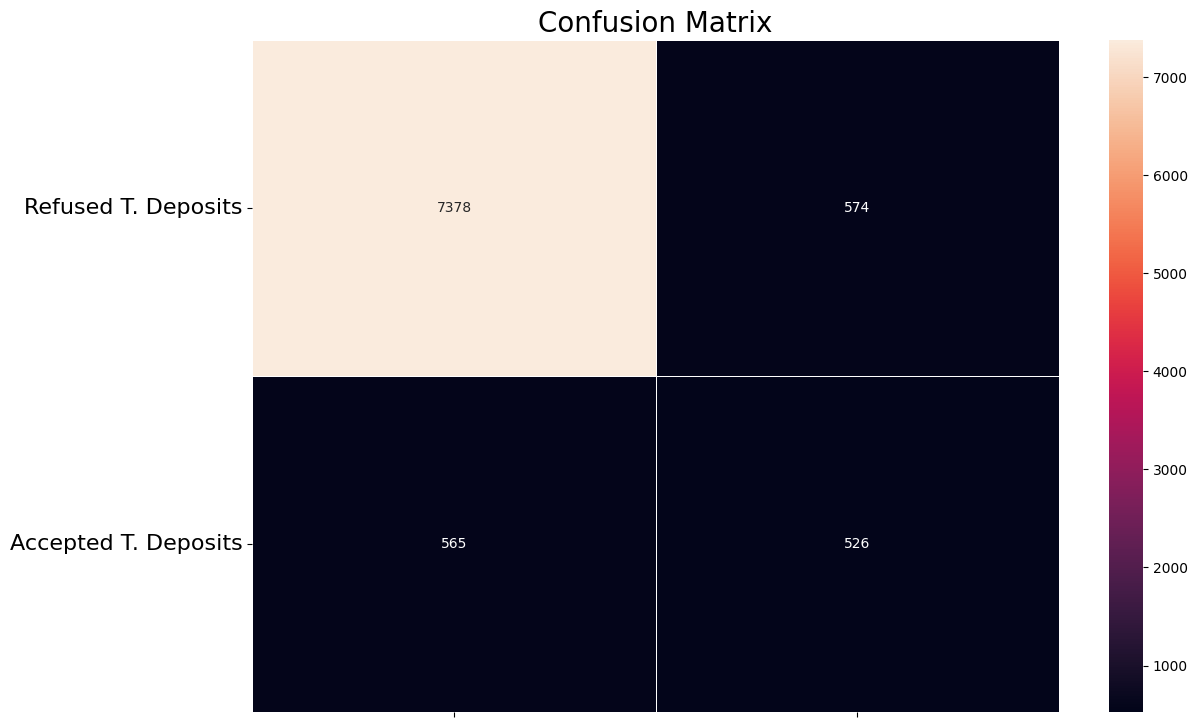

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

### ROC Curve for Decision Tree

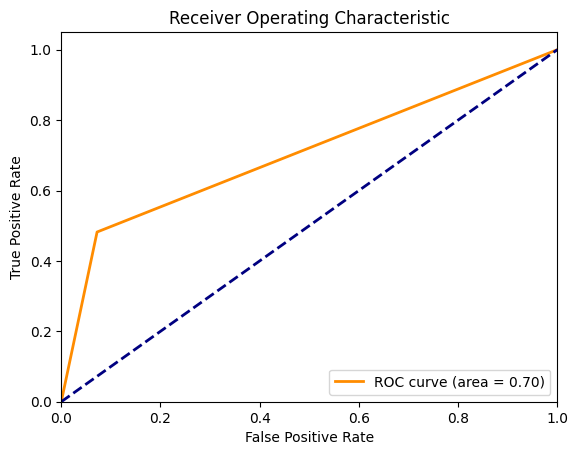

In [18]:
y_pred_proba = dt.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve for Decision Tree

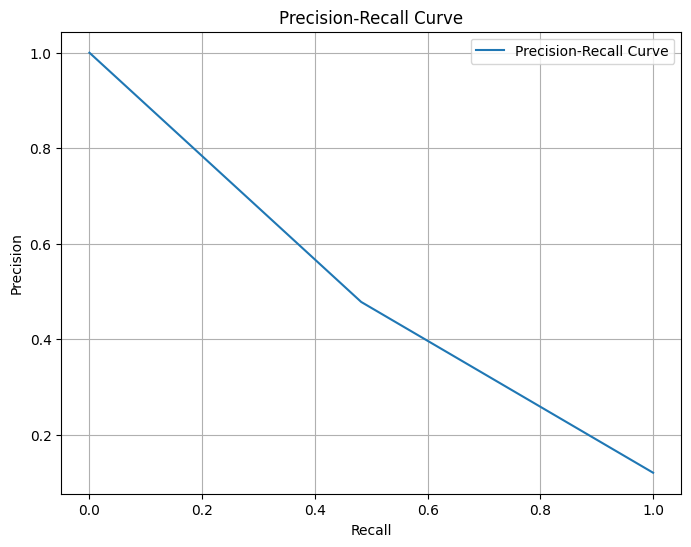

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Generated Decision Tree

In [20]:
#plt.figure(figsize=(20, 10))
#tree.plot_tree(dt, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
#plt.title('Decision Tree for Bank Marketing Campaign')
#plt.show()

### Finding importance rate of each feature in Decision Tree

Feature importance ranking:
1. Feature 11 (0.513799)
2. Feature 13 (0.102915)
3. Feature 8 (0.097924)
4. Feature 10 (0.097532)
5. Feature 15 (0.071267)
6. Feature 6 (0.047296)
7. Feature 0 (0.045423)
8. Feature 5 (0.013208)
9. Feature 12 (0.005167)
10. Feature 9 (0.002631)
11. Feature 3 (0.002346)
12. Feature 2 (0.000264)
13. Feature 14 (0.000227)
14. Feature 7 (0.000000)
15. Feature 4 (0.000000)
16. Feature 1 (0.000000)


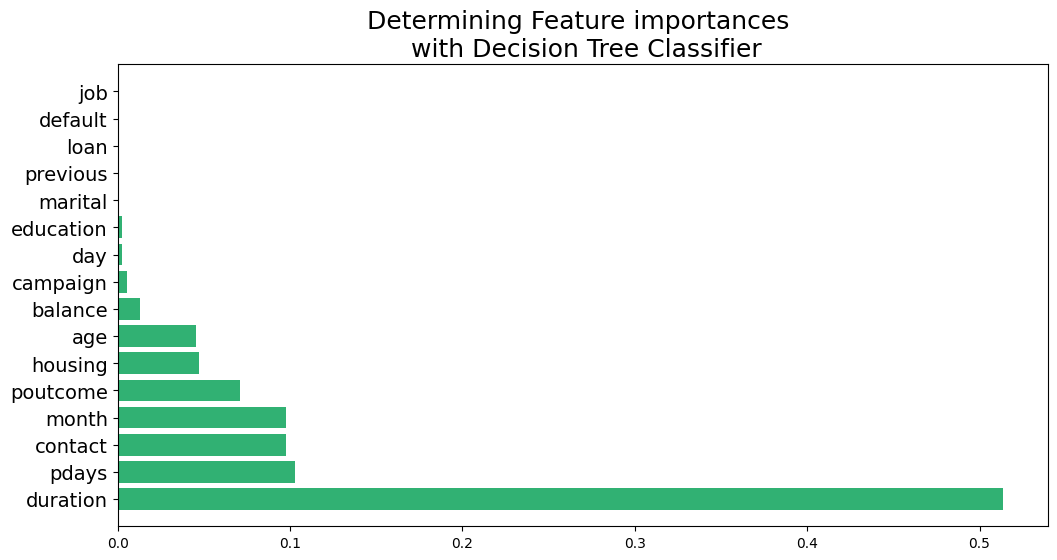

In [21]:
term_deposits = df.copy()

term_deposits['job'] = term_deposits['job'].astype('category').cat.codes
term_deposits['marital'] = term_deposits['marital'].astype('category').cat.codes
term_deposits['education'] = term_deposits['education'].astype('category').cat.codes
term_deposits['contact'] = term_deposits['contact'].astype('category').cat.codes
term_deposits['poutcome'] = term_deposits['poutcome'].astype('category').cat.codes
term_deposits['month'] = term_deposits['month'].astype('category').cat.codes
term_deposits['default'] = term_deposits['default'].astype('category').cat.codes
term_deposits['loan'] = term_deposits['loan'].astype('category').cat.codes
term_deposits['housing'] = term_deposits['housing'].astype('category').cat.codes

target_name = 'y'
X = term_deposits.drop('y', axis=1)

label=term_deposits[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,label,test_size=0.2, random_state=42, stratify=label)

tree = DecisionTreeClassifier(
    class_weight='balanced',
    min_weight_fraction_leaf = 0.01
)

tree = tree.fit(X_train, y_train)
importances = tree.feature_importances_
feature_names = term_deposits.drop('y', axis=1).columns
indices = np.argsort(importances)[::-1]

print("Feature importance ranking:")

for f in range(X_train.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Determining Feature importances \n with Decision Tree Classifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#31B173',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

## GradientBoosting Classifier

In [22]:
gb_df = pd.read_csv('bank-full.csv', sep=';')

categorical_columns = gb_df.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    le = LabelEncoder()
    gb_df[column] = le.fit_transform(gb_df[column])
    label_encoders[column] = le

X = gb_df.drop('y', axis=1)
y = gb_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(random_state=42)
time_start = time.time()
gb.fit(X_train, y_train)
time_end = time.time()
gb_time = time_end - time_start

y_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy score: {:.2f}%".format(100 * gb_accuracy))
print("Precision score: {:.2f}%".format(100 * gb_precision))
print("Recall score: {:.2f}%".format(100 * gb_recall))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      7952
           1       0.65      0.40      0.50      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043

Accuracy score: 90.19%
Precision score: 65.22%
Recall score: 40.05%


In [23]:
gb_train_score = gb.score(X_train, y_train)

print(f"Training Score for Gradient Boosting: {gb_train_score:.4f}")
print(f"Training Time for Gradient Boosting: {gb_time:.2f} s")

log_scores = cross_val_score(gb, X_train, y_train, cv=3)
gb_log_reg_mean = log_scores.mean()

print(f"Crossval Mean Score for Gradient Boosting: {gb_log_reg_mean:.4f}")

Training Score for Gradient Boosting: 0.9098
Training Time for Gradient Boosting: 4.21 s
Crossval Mean Score for Gradient Boosting: 0.9039


### Confusion Matrix for Gradient Boosting

Confusion Matrix:
[[7719  233]
 [ 654  437]]


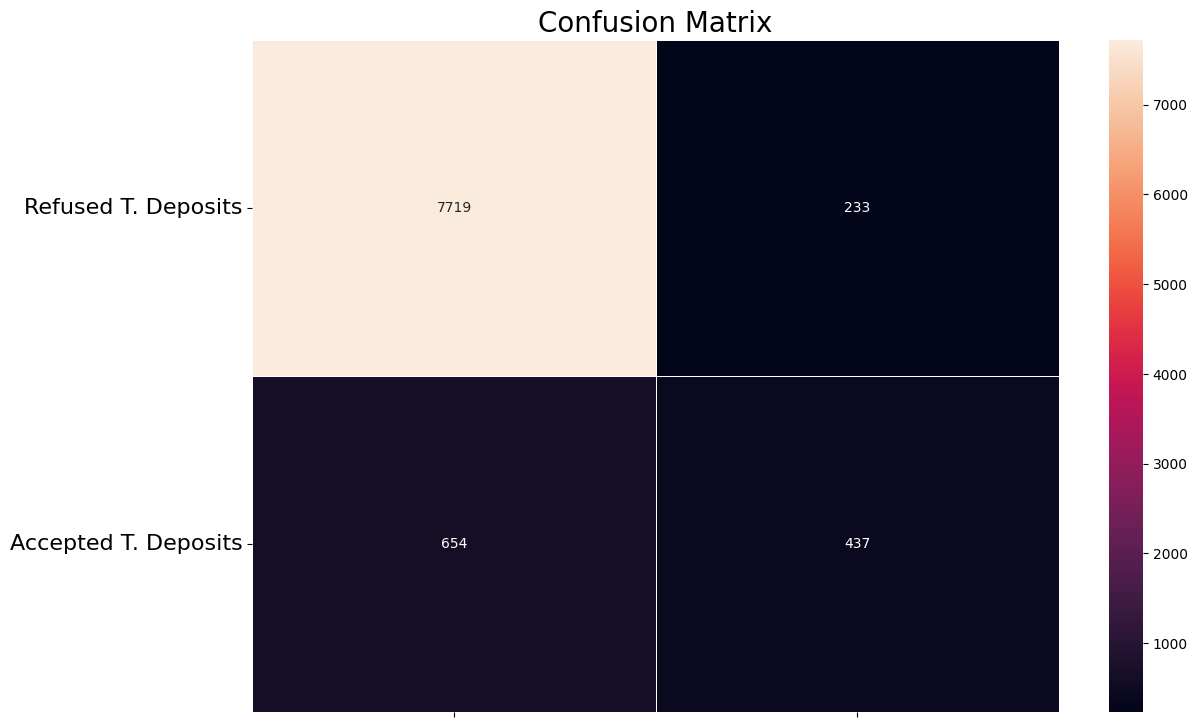

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)

print(f"Confusion Matrix:\n{conf_matrix}")

### ROC Curve for Gradient Boosting

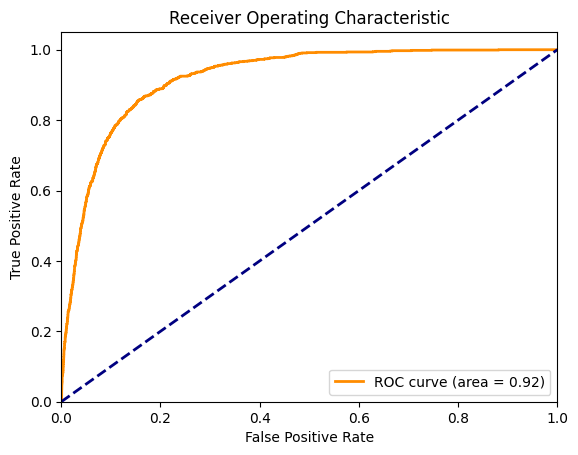

In [25]:
y_pred_proba = gb.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve for Gradient Boosting

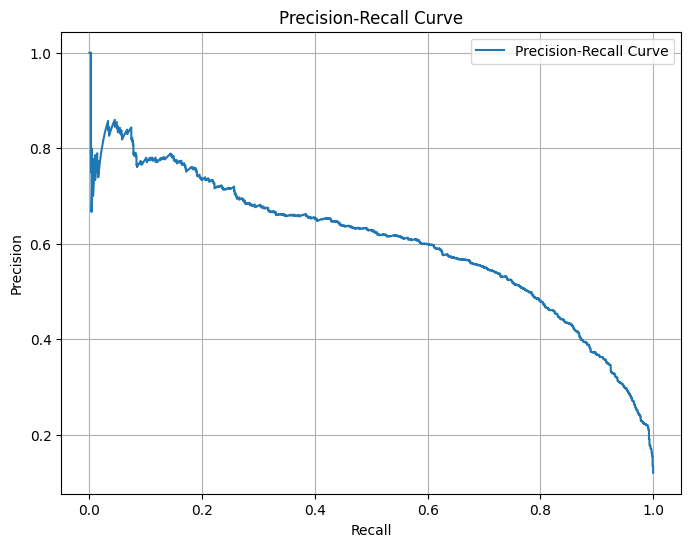

In [26]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

## Classifiers comparison

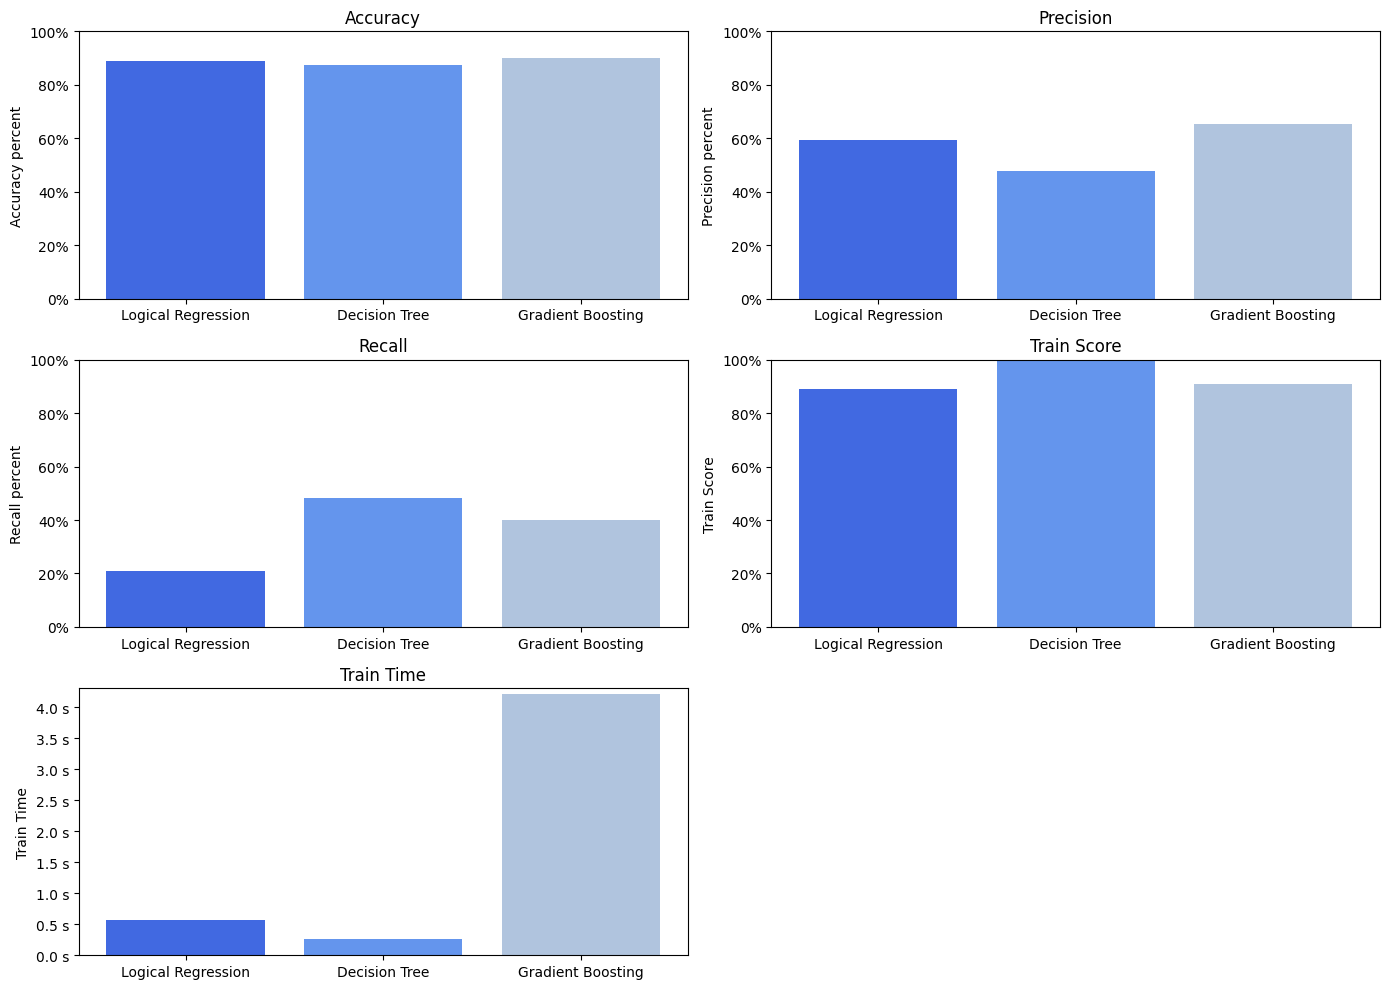

In [27]:
models      = ['Logical Regression', 'Decision Tree', 'Gradient Boosting']
accuracy    = [lr_accuracy * 100, dt_accuracy * 100, gb_accuracy * 100]
precision   = [lr_precision * 100, dt_precision * 100, gb_precision * 100]
recall      = [lr_recall * 100, dt_recall * 100, gb_recall * 100]
train_score = [lr_train_score * 100, dt_train_score * 100, gb_train_score * 100]
train_time  = [lr_time, dt_time, gb_time]

def percent(x, pos):
    return '%1.0f%%' % x

def seconds(x, pos):
    return '%1.1f s' % x

fig, axs = plt.subplots(3, 2, figsize=(14, 10))

axs[0, 0].bar(models, accuracy, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylabel('Accuracy percent')
axs[0, 0].set_ylim(0, 100)
axs[0, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[0, 1].bar(models, precision, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[0, 1].set_title('Precision')
axs[0, 1].set_ylabel('Precision percent')
axs[0, 1].set_ylim(0, 100)
axs[0, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 0].bar(models, recall, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 0].set_title('Recall')
axs[1, 0].set_ylabel('Recall percent')
axs[1, 0].set_ylim(0, 100)
axs[1, 0].yaxis.set_major_formatter(FuncFormatter(percent))

axs[1, 1].bar(models, train_score, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[1, 1].set_title('Train Score')
axs[1, 1].set_ylabel('Train Score')
axs[1, 1].set_ylim(0, 100)
axs[1, 1].yaxis.set_major_formatter(FuncFormatter(percent))

axs[2, 0].bar(models, train_time, color=['royalblue', 'cornflowerblue', 'lightsteelblue'])
axs[2, 0].set_title('Train Time')
axs[2, 0].set_ylabel('Train Time')
axs[2, 0].set_ylim(0, max(train_time) + 0.1)
axs[2, 0].yaxis.set_major_formatter(FuncFormatter(seconds))

fig.delaxes(axs[2, 1])
plt.tight_layout()
plt.show()

## Classification Model

In [ ]:
term_deposits = df.copy()
dep = term_deposits['y']
term_deposits.drop(labels=['y'], axis=1,inplace=True)
term_deposits.insert(0, 'y', dep)
term_deposits.head()

term_deposits["housing"].value_counts()/len(term_deposits)

In [ ]:
term_deposits["loan"].value_counts() / len(term_deposits)

## Optimization of hyperparameters

In [ ]:
# parameter_space = {
#    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam'],
#    'alpha': [0.0001, 0.05],
#    'learning_rate': ['constant','adaptive'],
# }
# clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train)
# print("Best param:", clf.best_params_)
